In [1]:
### Bottomonium ERT implementation 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.linalg import block_diag
from scipy.sparse import diags
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import eigs
from math import factorial

In [2]:
hbarc = 0.1973
def dag(array):
    return array.T.conj()

class ERTens: #AkL list of dissapators w/ sqrt(Γ) inc. that are functions of (t) <- also H
    def __init__(self, H, AkL, dt, psiI, R=None, init_t=None):
        self.H = H #Hamiltonian
        self.AkL = AkL #Dissipators
        self.K = len(AkL) 
        self.dt = dt #Explicit time step
        self.psiL = np.array([psiI])
        self.R = np.power(2*len(AkL),2) if R==None else R #Truncation size
        self.t = 0.0 if init_t==None else init_t
    def Jk(self, A):
        #print(self.H.shape)
        #print('TYPE A: ',type(A))
        #print('SHAPE A: ',A.shape)
        #print('SHAPE H: ',self.H(self.t).shape)
        return (-1j*self.H(self.t))+((self.K/2)*((A@A)-(dag(A)@A)))
    def Uk(self, A):
        return expm((self.dt*self.Jk(A))-(1j*np.sqrt(self.K*self.dt)*A))
    def Vk(self, A):
        return expm((self.dt*self.Jk(A))+(1j*np.sqrt(self.K*self.dt)*A))
    def step(self):
        nPsi = []
        for A in self.AkL:
            for psi in self.psiL:
                nPsi.append(self.Uk(A(self.t))@psi)
                nPsi.append(self.Vk(A(self.t))@psi)
        nPsi = np.array(nPsi)
        Sij = np.dot(nPsi.conj(),nPsi.T)
        w, Uuns = np.linalg.eigh(Sij)
        #w, Uuns = eigs(Sij, k=self.R, which='LM')
        idx = np.argsort(w)[::-1]
        Ulk = Uuns[:,idx]
        if len(nPsi) > self.R:
            UR = Ulk.T.conj()[:self.R]/np.sqrt(2*self.K)
        else:
            UR = Ulk.T.conj()
        rPsi = UR@nPsi
        self.psiL = rPsi
        self.t += self.dt
    def obs(self, O):
        return np.mean(np.array([psi.conj()@O@psi for psi in self.psiL]))
    def tick(self, O):
        self.step()
        return self.obs(O)

/home/jacob/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


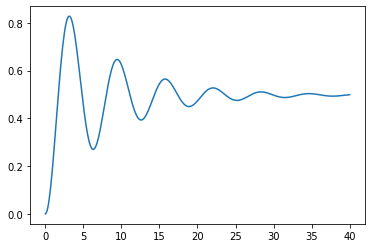

In [3]:
# Optical Bloch Test

Sx = np.array([[0,1],[1,0]])
Sp = np.array([[0,1],[0,0]])
Sm = dag(Sp)
Es = np.array([1,0])
Gs = np.array([0,1])
I2 = np.array([[1,0],[0,1]])

pE = np.array([[1,0],[0,0]])

Om = 1 # This makes it such that t = t*Om
Δ = 0
Γ = Om/6
g=np.sqrt(Γ)

Hopt = -((Om/2)*Sx)-(Δ*(Sp@Sm))
Heff = Hopt - ((1j*Γ/2)*(Sp@Sm))

Aobe = lambda t: Sm*g

OBT = ERTens(lambda t:Hopt, [Aobe], 0.1, Gs, R=2)
Ndt = 400
res = np.array([OBT.tick(pE) for i in range(400)])
res = np.insert(res, 0, Gs@pE@Gs)
plt.plot(np.linspace(0,40,401), res)
plt.show()

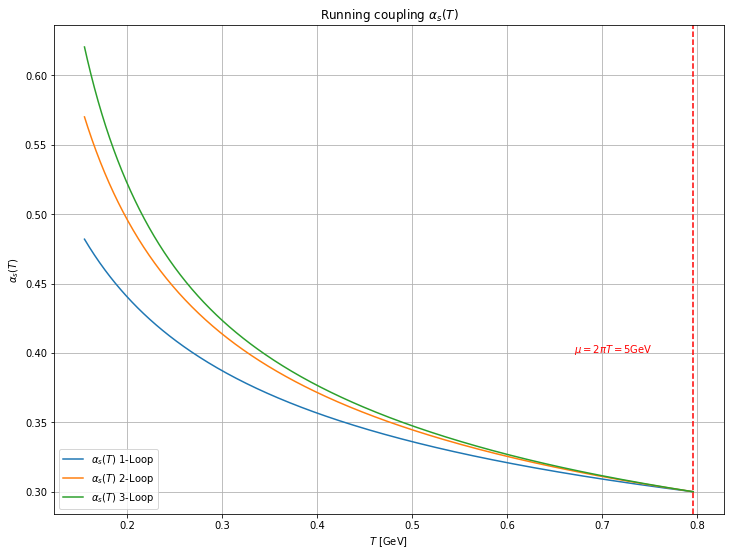

In [4]:
##### Running Coupling #####

NF = 2
NC = 3

# QCD beta coeffs
B0=(11*NC-2*NF)/(12*np.pi)
B1=(17*NC*NC-NF*(10*NC+6*(NC*NC-1)/(2*NC))/2)/(24*np.pi*np.pi)
B2=(2857 - 5033*NF/9 + 325*NF*NF/27)/(128*np.pi*np.pi*np.pi) 

### QCD beta function at N-Loops
def BetaF1(mu, aS):
    return -B0*np.power(aS,2) 
def BetaF2(mu, aS):
    return -B0*np.power(aS,2) - B1*np.power(aS,3) 
def BetaF3(mu, aS):
    return -B0*np.power(aS,2) - B1*np.power(aS,3) - B2*np.power(aS,4)

alpha_0 = 0.3  # Initial value of alpha_s at mu0
mu_0 = 5  # Reference scale in GeV

mu_range = np.logspace(np.log10(2*np.pi*0.155), np.log10(mu_0), 500)[::-1] # T=0.155GeV to mu=5GeV 

sol1 = solve_ivp(
    BetaF1,  # Function to integrate
    [np.log(mu_range[0]), np.log(mu_range[-1])],  # Integration bounds in log(mu)
    [alpha_0],  # Initial condition
    t_eval=np.log(mu_range)  # Points to evaluate the solution
)
sol2 = solve_ivp(
    BetaF2,  # Function to integrate
    [np.log(mu_range[0]), np.log(mu_range[-1])],  # Integration bounds in log(mu)
    [alpha_0],  # Initial condition
    t_eval=np.log(mu_range)  # Points to evaluate the solution
)
sol3 = solve_ivp(
    BetaF3,  # Function to integrate
    [np.log(mu_range[0]), np.log(mu_range[-1])],  # Integration bounds in log(mu)
    [alpha_0],  # Initial condition
    t_eval=np.log(mu_range)  # Points to evaluate the solution
)

# Extract the solution
alpha_s1 = sol1.y[0]
alpha_s2 = sol2.y[0]
alpha_s3 = sol3.y[0]

alphaS = interp1d(mu_range[::-1]/(2*np.pi),alpha_s3[::-1],kind='cubic',bounds_error=False, fill_value='extrapolate') #function of T

# Plot the running coupling
plt.figure(figsize=(12, 9))
plt.plot(mu_range/(2*np.pi), alpha_s1, label=r'$\alpha_s(T)$'+' 1-Loop')
plt.plot(mu_range/(2*np.pi), alpha_s2, label=r'$\alpha_s(T)$'+' 2-Loop')
plt.plot(mu_range/(2*np.pi), alpha_s3, label=r'$\alpha_s(T)$'+' 3-Loop')

plt.axvline(x=mu_0/(2*np.pi), color='r', linestyle='--')
plt.text(0.67, 0.4, r'$\mu= 2 \pi T = 5 $'+'GeV', color='r', ha='left')


plt.xlabel(r'$T$ [GeV]')
plt.ylabel(r'$\alpha_s(T)$')
plt.title('Running coupling '+r'$\alpha_s(T)$')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
########## Bottomonium system ##########


##### Parameters #####
NPts = 512
RMax = 20 # [GeV]
kSet = 0 # kappa setting
Tc = 0.155 # [GeV]
m = 4.73 # [GeV] bottom quark mass
#m=m/2

# Kappa function
def κ(T):
    Ts = T/Tc
    if kSet == 0:
        return 1/(0.00397*np.power(Ts, 3/2) - 0.08341*Ts + 0.98031*np.power(Ts, 1/2) - 0.51889)
    
##### Potentials #####

### Munich Potential
## Real
aM = 0.3
def VsR(r,T):
    return -(alphaS(T)/r) + ((1/2)*gam*np.power(T,3)*np.power(r,2))
def VoR(r,T):
    return -((1/8)*(alphaS(T)/r)) + ((7/32)*gam*np.power(T,3)*np.power(r,2))
## Imaginary
def VsI(r,T):
    return -(1/2)*κ(T)*np.power(T,3)*np.power(r,2)
def VoI(r,T):
    return -(7/32)*κ(T)*np.power(T,3)*np.power(r,2)

### KSU Isotropic
gam = -1.75
Fmd = 1
alpha = 0.6239853 # alphaS *(4/3)
a_EC = 0.409 # effective coupling !!!used in VisoKMS -> might be alpha
sigma = 0.21 # [GeV^2] string tension
rsb = 1.25/hbarc # string breaking distance = 1.25fm
LAMBDA_MS = 0.344;
      

## Phi function
def T2expOsx(N): # returns function expansion of T2 with n terms aprox O(2n) small x
    return lambda r, z: sum((-1)**k * np.power(z*r,2*k) / factorial(2*k+1) for k in range(N)) 
def T2expOLx(N): # returns function expansion of T2 with n terms aprox O(2n) large x
    return lambda r, z: sum(
        (-1)**k * (np.cos(z*r) / (z*r)**(2*k+1) if k % 2 == 0 else np.sin(z*r) / (z*r)**(2*k+1)) for k in range(N)) 
def intPhi(N):
    zMax = 15
    rT = np.linspace(0.001,2*RMax,500)
    swPt = 1
    res = []
    for ri in rT:
        #print('intPhi: ',ri)
        integrand = lambda z: (z/(((z**2)+1)**2)) * (1-(np.sin(z*ri)/(z*ri)))
        #integrand = lambda z: np.piecewise(z,[z*ri<swPt,z*ri>=swPt],  
                                           #[(z/(((z**2)+1)**2)) * (1-T2expOsx(N)(ri,z)),
                                           #(z/(((z**2)+1)**2)) * (1-T2expOLx(N)(ri,z))])
        integral_result, _ = quad(integrand, 0.05, zMax)
        res.append([ri,2*integral_result])
    return np.array(res) #function of rhat
#phiDat = intPhi2(40)
#phiInt = interp1d(phiDat[:,0],phiDat[:,1],kind='cubic',bounds_error=False, fill_value='extrapolate')

def mD(T): # Debeye mass
    return Fmd*T*np.sqrt(NC*(1+(NF/6))*np.pi*((4/3)*alphaS(T)))

## Real
def Vvac(r):
    return np.piecewise(r,
                       [r<=rsb, r>rsb],
                       [lambda r: -(a_EC/r)+(sigma*r), lambda r:-(a_EC/rsb)+(sigma*rsb)])
def VisoKMS(r,T):
    mD_r = mD(T)*r
    with np.errstate(divide='ignore', invalid='ignore'):
        return -(a_EC/r)*(1+(mD_r))*np.exp(-mD_r) + ((2*sigma/mD(T))*(1-np.exp(-mD_r))) - (sigma*r*np.exp(-mD_r))
def VisoR(r,T):
    return np.where(VisoKMS(r,T) <= Vvac(r), VisoKMS(r,T), Vvac(r))

## Imaginary

def VisoI(r,T):
    return -alphaS(T)*(4/3)*T*phiInt(r*mD(T))

##### Hamiltonain #####

# position operator (partial - one block) 
rv = np.linspace(0.1, RMax, NPts)
rs = np.diag(rv)
ris = np.diag(1/rv)
dr = rv[1]-rv[0]

# Central difference
ps = -1j*(((np.diag(np.ones(NPts-1),1)-np.diag(np.ones(NPts-1),-1))/(2*dr)) + ris)
ps = -1j*(np.diag(np.ones(NPts-1),1)-np.diag(np.ones(NPts-1),-1))/(2*dr)

#Kinetic Energy operator
lapfac = 1/(m * dr**2)
Tkin = np.diag(np.full(NPts, 2.0)*(lapfac+m)) + np.diag(np.full(NPts-1, -1.0)*lapfac, k=1) + np.diag(np.full(NPts-1, -1.0)*lapfac, k=-1)

#Angular Momentum vec
def Lmom(l):
    return l*(l+1)/(m*np.power(rv,2))

#Potential Operator
def Vs(r,T):
    return np.diag(VsR(r,T) + 1j*VsI(r,T))
def Vo(r,T):
    return np.diag(VoR(r,T) + 1j*VoI(r,T))

def Hs(T):
    return Tkin+Vs(rv,T)
def Ho(T):
    return Tkin+Vo(rv,T)

### [s,o] Blocks

def Hbot(T):
    return np.block([[Hs(T),np.zeros((NPts, NPts))],[np.zeros((NPts, NPts)),Ho(T)]])

def HMunichS(T, l):
    return Tkin + np.diag(VsR(rv,T) + 1j*VsI(rv,T) + Lmom(l))
def HMunichO(T, l):
    return Tkin + np.diag(VoR(rv,T) + 1j*VoI(rv,T) + Lmom(l))

def HisoS(T, l):
    return Tkin + np.diag(VisoR(rv,T) + 1j*VisoI(rv,T) + Lmom(l))

def compVacEigS(Vr, l): #Vr-funciton of r only (lambda out T) # l-angular momenutm?
    eigenvalues, eigenvectors = np.linalg.eig(np.diag(Vr(rv) + (l*(l+1)/(m*np.power(rv,2))))+Tkin)
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors

def compBasis(H_L, L_list): #H_L-H function of only l,  L_list = [N-s-states, N-p-states, N-d-states, ...]
    res = {}
    stLet = ['S','P','D']
    for i, Ln in enumerate(L_list):
        eigenvalues, eigenvectors = np.linalg.eig(H_L(i))
        idx = np.argsort(eigenvalues)
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        for j in range(Ln):
            res[str(j+1)+stLet[i]] = {'m':eigenvalues[j],'wf':eigenvectors[:,j]}
    return res
            
C0con = np.block([[np.zeros((NPts, NPts)),np.diag(rv)],[np.diag(rv)*np.sqrt(NC**2 -1),np.zeros((NPts, NPts))]])
C1con = np.block([[np.zeros((NPts, NPts)),np.zeros((NPts, NPts))],[np.zeros((NPts, NPts)),np.diag(rv)]])
def genC(so,ri): #so-upper index ri-lower index(corresponds to different spatial directions r_i)
    if 0 == so:
        return lambda T: np.sqrt(κ(T)/(NC**2 -1))*C0con #Nc=3 => Nc^2 - 1 = 8
    if 1 == so:
        return lambda T: np.sqrt((NC**2 - 4)*κ(T)/(2*(NC**2 - 1)))*C1con #Nc=3 => (Nc^2-4)/(2(Nc^2-1)) = 5/16        
        
        

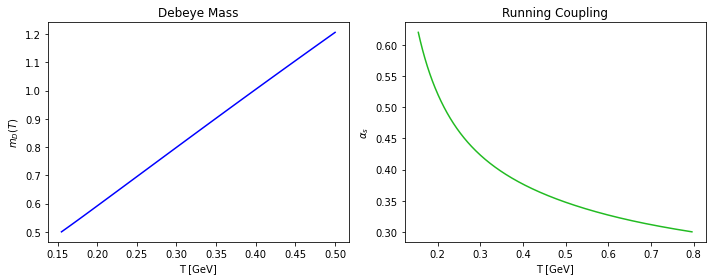

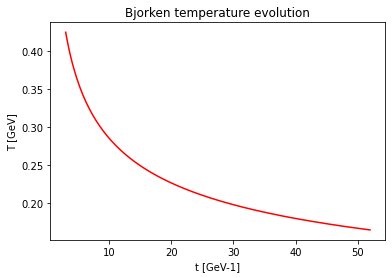

In [6]:
Tls = np.linspace(0.155,0.5,100)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

axs[0].plot(Tls, mD(Tls), color='b')
axs[0].set_title('Debeye Mass')
axs[0].set_xlabel('T [GeV]')
axs[0].set_ylabel(r'$m_D(T)$')

plt.plot(mu_range/(2*np.pi), alphaS(mu_range/(2*np.pi)), label=r'$\alpha_s(T)$'+' 3-Loop', color='#22BB22')
axs[1].set_title('Running Coupling')
axs[1].set_xlabel('T [GeV]')
axs[1].set_ylabel(r'$\alpha_s$')

plt.tight_layout()
plt.show()

BjT = np.loadtxt('BjorkenTemp.tsv', delimiter='\t')
BjTi = interp1d(BjT[:,0],BjT[:,1],kind='cubic')
plt.plot(BjT[:,0]/hbarc,BjT[:,1],color='red')
plt.title('Bjorken temperature evolution')
plt.ylabel('T [GeV]')
plt.xlabel('t [GeV-1]')
plt.show()

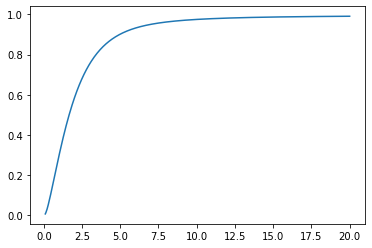

In [7]:
phiDat = intPhi(40)
phiInt = interp1d(phiDat[:,0],phiDat[:,1],kind='cubic',bounds_error=False, fill_value='extrapolate')
plt.plot(rv,phiInt(rv))
plt.show()

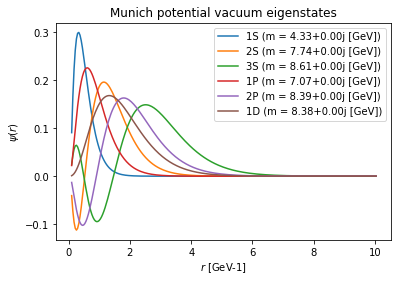

In [8]:
MunichVEigS = compBasis(lambda l: HMunichS(0, l), [3,2,1])
for st, item in MunichVEigS.items():
    plt.plot(rv[:int(NPts/2)],item['wf'][:int(NPts/2)], label=f"{st} (m = {item['m']:.2f} [GeV])")

plt.title('Munich potential vacuum eigenstates')
plt.xlabel(r'$r$'+' [GeV-1]')
plt.ylabel(r'$\psi(r)$')

plt.legend()
plt.show()

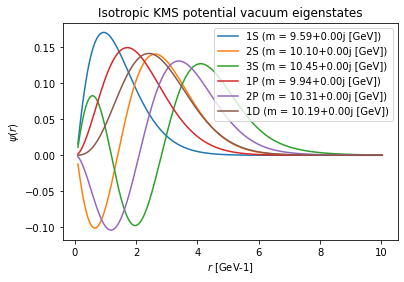

In [9]:
KMSVEigS = compBasis(lambda l: HisoS(0, l), [3,2,1])
for st, item in KMSVEigS.items():
    plt.plot(rv[:int(NPts/2)],item['wf'][:int(NPts/2)], label=f"{st} (m = {item['m']:.2f} [GeV])")

plt.title('Isotropic KMS potential vacuum eigenstates')
plt.xlabel(r'$r$'+' [GeV-1]')
plt.ylabel(r'$\psi(r)$')

plt.legend()
plt.show()

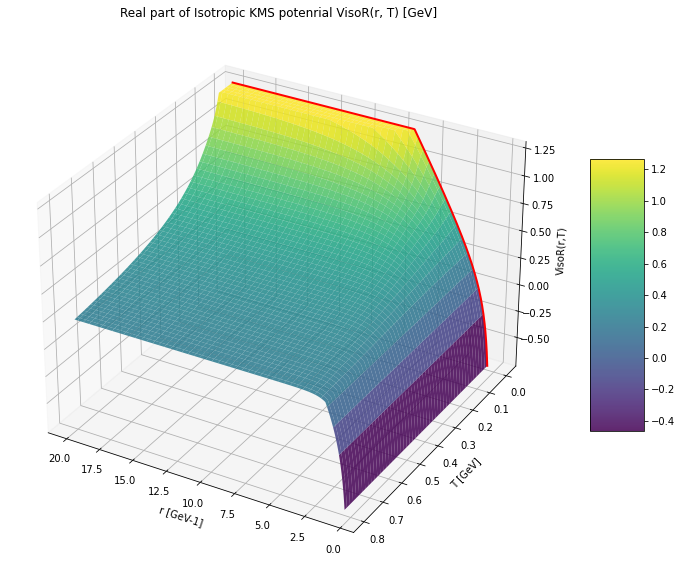

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create an r, T grid
TR = np.linspace(0,mu_0/(2*np.pi),200)  # T values from 0 to reference mu_0 = 5 GeV
rvT = rv[10:]


# Create meshgrid
RM, TM = np.meshgrid(rvT, TR)

Z = VisoR(RM, TM)
#Z = np.flip(Z,axis=0)

#Intersect-handover
Z1, Z2 = Vvac(RM), VisoKMS(RM,TM)
diff = np.abs(Z1 - Z2)
intersection_mask = diff < 0.01  # Intersection threshold

R_inter = RM[intersection_mask]
T_inter = TM[intersection_mask]
Z_inter = Z1[intersection_mask]

# Plotting
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(RM, TM, Z, cmap='viridis', edgecolor='none', alpha=0.85)

ax.plot(rvT, np.linspace(0,0,len(rvT)), Vvac(rvT), color='red', linewidth=2, zorder=10)

### INTER
#ax.scatter(R_inter, T_inter, Z_inter, color='blue', s=5, label="Intersection")

# Labels
ax.set_xlabel('r [GeV-1]')
ax.set_ylabel('T [GeV]')
ax.set_zlabel('VisoR(r,T)')
ax.set_title('Real part of Isotropic KMS potenrial VisoR(r, T) [GeV]')

ax.view_init(elev=30, azim=120)

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


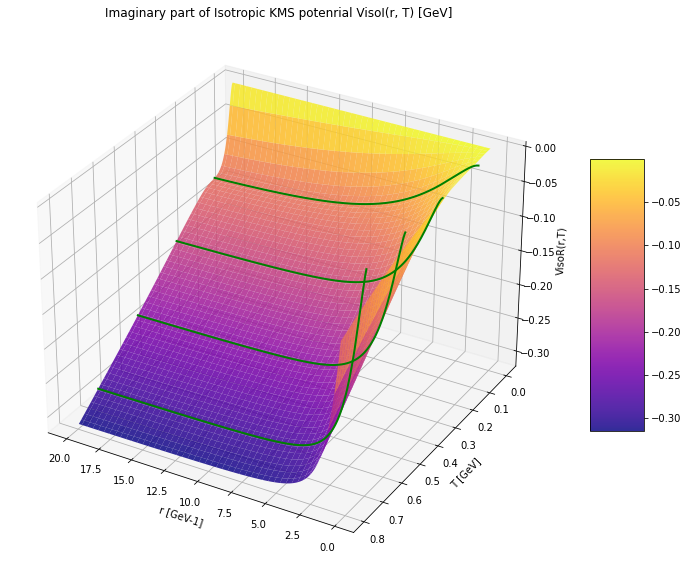

In [11]:
# Create an r, T grid
TR = np.linspace(0,mu_0/(2*np.pi),200)  # T values from 0 to reference mu_0 = 5 GeV
rvT = rv

ZI = VisoI(RM, TM)
#Z = np.flip(Z,axis=0)

# Plotting
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(RM, TM, ZI, cmap='plasma', edgecolor='none', alpha=0.85)

TiP = 0.1
ax.plot(rvT, np.linspace(TiP,TiP,len(rvT)), VisoI(rvT,TiP), color='green', linewidth=2, zorder=10)
TiP = 0.3
ax.plot(rvT, np.linspace(TiP,TiP,len(rvT)), VisoI(rvT,TiP), color='green', linewidth=2, zorder=10)
TiP = 0.5
ax.plot(rvT, np.linspace(TiP,TiP,len(rvT)), VisoI(rvT,TiP), color='green', linewidth=2, zorder=10)
TiP = 0.7
ax.plot(rvT, np.linspace(TiP,TiP,len(rvT)), VisoI(rvT,TiP), color='green', linewidth=2, zorder=10)

# Labels
ax.set_xlabel('r [GeV-1]')
ax.set_ylabel('T [GeV]')
ax.set_zlabel('VisoR(r,T)')
ax.set_title('Imaginary part of Isotropic KMS potenrial VisoI(r, T) [GeV]')

ax.view_init(elev=30, azim=120)

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


0.6
0.65
0.7000000000000001
0.7500000000000001
0.8000000000000002
0.8500000000000002
0.9000000000000002
0.9500000000000003
1.0000000000000002


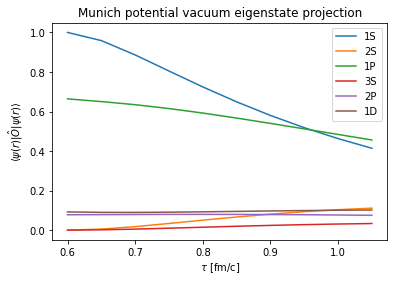

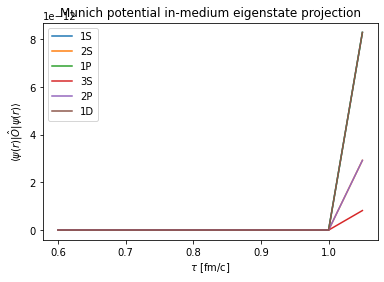

In [12]:
### Run ERT on 
C0t, C1t = genC(0,0), genC(1,0)
botAkL = [lambda t: C0t(BjTi(t)), lambda t: C1t(BjTi(t))]
PsiI = np.concatenate([MunichVEigS['1S']['wf'],np.linspace(0,0,NPts)])
HMunich = lambda t: np.block([[HMunichS(BjTi(t), 0),np.zeros((NPts, NPts))],[np.zeros((NPts, NPts)),HMunichO(BjTi(t), 0)]])
botERT = ERTens(HMunich, botAkL, 0.05, PsiI, R=4, init_t=0.6)

stList = ['1S','2S','1P','3S','2P','1D']
resML = {st:[] for st in stList}
resVL = {st:[] for st in stList}
EigMunV = compBasis(lambda l:HMunichS(0,l), [3,2,1])
tx = [0.6]
nt = 10
for ti in range(nt):
    if ti != 0:
        print(botERT.t)
        botERT.step()
        tx.append(botERT.t)
    EigMun = compBasis(lambda l:HMunichS(BjTi(botERT.t),l), [3,2,1])
    for st in stList:
        psiBV = np.concatenate([EigMunV[st]['wf'],np.linspace(0,0,NPts)])
        VO = np.outer(psiBV,psiBV)
        resVL[st].append(botERT.obs(VO))
        psiB = np.concatenate([EigMun[st]['wf'],np.linspace(0,0,NPts)])
        MO = np.outer(psiB,psiB)
        resML[st].append(botERT.obs(MO))

    
for st in stList:
    plt.plot(tx, resVL[st], label=st)
plt.title('Munich potential vacuum eigenstate projection')
plt.xlabel(r'$\tau$'+' [fm/c]')
plt.ylabel(r'$\langle \psi(r) | \hat{O} | \psi(r) \rangle$')
plt.legend()
plt.show()

for st in stList:
    plt.plot(tx, resML[st], label=st)
plt.title('Munich potential in-medium eigenstate projection')
plt.xlabel(r'$\tau$'+' [fm/c]')
plt.ylabel(r'$\langle \psi(r) | \hat{O} | \psi(r) \rangle$')
plt.legend()
plt.show()

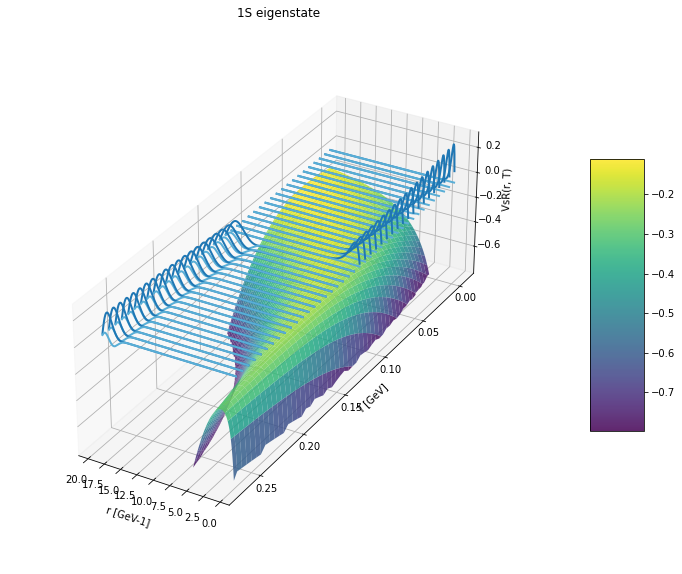

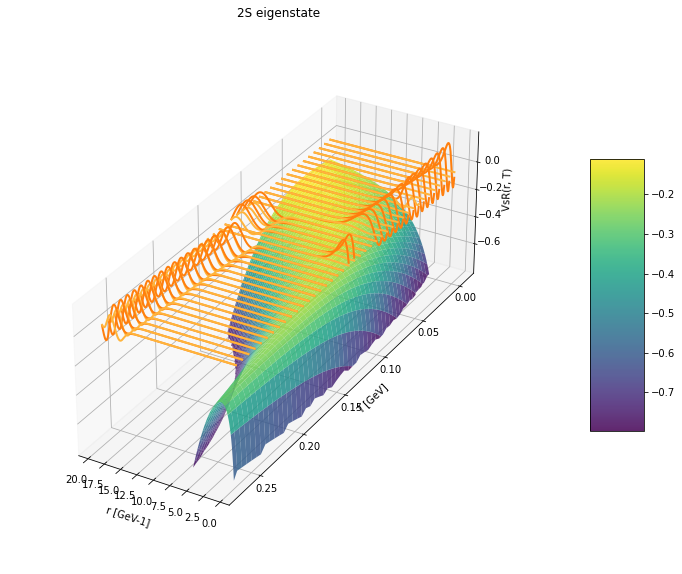

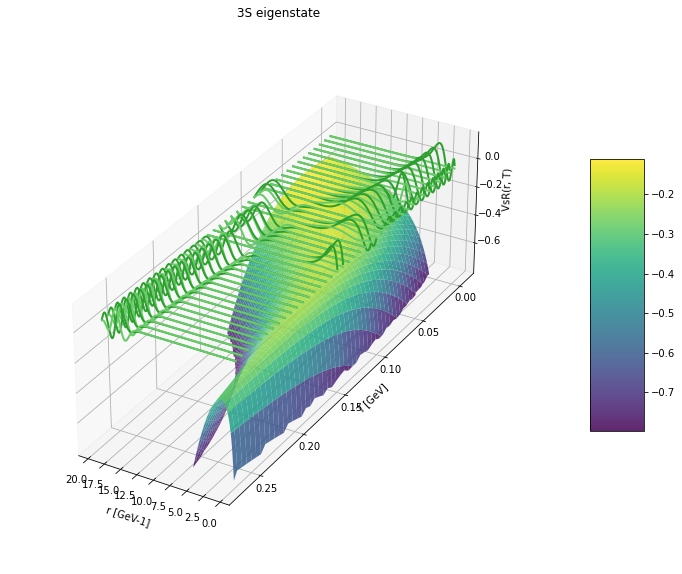

In [13]:
# Create an r, T grid
TR = np.linspace(0,mu_0/(6*np.pi),200)  # T values from 0 to reference mu_0 = 5 GeV
rvT = rv

# Create meshgrid
RM, TM = np.meshgrid(rvT, TR)

stretch_factor = 3
NTwf = 40

ZI = VsR(RM, TM) 
ZIM = np.ma.masked_where(ZI < -0.8, ZI)
#Z = np.flip(Z,axis=0)

colKey = {'1S':(31/255, 119/255, 180/255),'2S':(255/255, 127/255, 14/255),'3S':(44/255, 160/255, 44/255)}
Tempi = np.linspace(0,mu_0/(6*np.pi),NTwf)
eigL = []
for Ti in Tempi:
    eigL.append([Ti,compBasis(lambda l:HMunichS(Ti,l), [3])])

for st in ['1S','2S','3S']:
    # Plotting
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Surface plot
    surf = ax.plot_surface(RM, TM, ZIM, cmap='viridis', edgecolor='none', alpha=0.85)
    #ax.set_zlim(-2, 1)  # Adjust the z-axis range as needed
    #ax.set_zscale('log')  # Log scale for surface plot
    ax.set_box_aspect([1, stretch_factor, 1])
    for i in range(len(eigL)):
        ax.plot(rvT, np.linspace( eigL[i][0], eigL[i][0],len(rvT)), eigL[i][1][st]['wf'].real, color=colKey[st], linewidth=2, zorder=10)
        ax.plot(rvT, np.linspace( eigL[i][0], eigL[i][0],len(rvT)), eigL[i][1][st]['wf'].imag, color=tuple(np.sqrt(np.array(colKey[st]))), linewidth=2, zorder=10)
    # Labels
    ax.set_xlabel('r [GeV-1]')
    ax.set_ylabel('T [GeV]')
    ax.set_zlabel('VsR(r, T)')
    ax.set_title(st+' eigenstate')
    ax.view_init(elev=30, azim=120)
    # Colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.show()

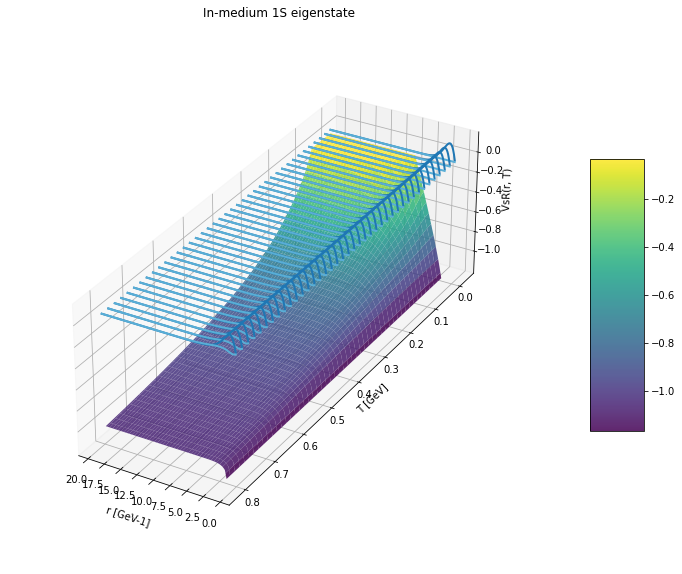

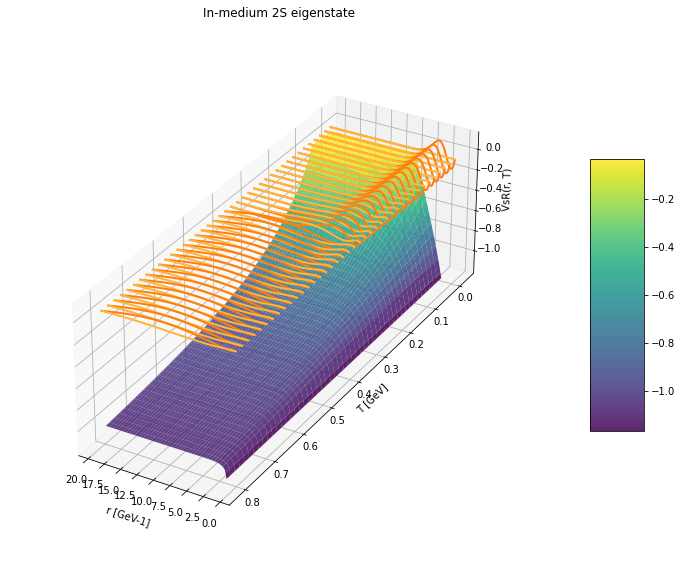

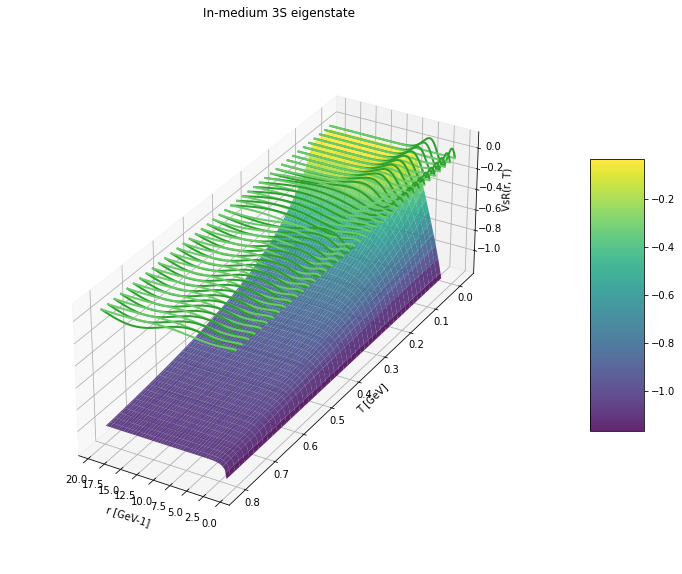

In [14]:
# Create an r, T grid
TR = np.linspace(0,mu_0/(2*np.pi),200)  # T values from 0 to reference mu_0 = 5 GeV
rvT = rv

# Create meshgrid
RM, TM = np.meshgrid(rvT, TR)

stretch_factor = 3
NTwf = 40

ZI = VisoR(RM, TM) - 1.3
ZIM = np.ma.masked_where(ZI < -1.2, ZI)
#Z = np.flip(Z,axis=0)

colKey = {'1S':(31/255, 119/255, 180/255),'2S':(255/255, 127/255, 14/255),'3S':(44/255, 160/255, 44/255)}
Tempi = np.linspace(0,mu_0/(2*np.pi),NTwf)
eigL = []
for Ti in Tempi:
    eigL.append([Ti,compBasis(lambda l:HisoS(Ti,l), [3])])

for st in ['1S','2S','3S']:
    # Plotting
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Surface plot
    surf = ax.plot_surface(RM, TM, ZIM, cmap='viridis', edgecolor='none', alpha=0.85)
    #ax.set_zlim(-2, 1)  # Adjust the z-axis range as needed
    #ax.set_zscale('log')  # Log scale for surface plot
    ax.set_box_aspect([1, stretch_factor, 1])
    for i in range(len(eigL)):
        ax.plot(rvT, np.linspace( eigL[i][0], eigL[i][0],len(rvT)), eigL[i][1][st]['wf'].real, color=colKey[st], linewidth=2, zorder=10)
        ax.plot(rvT, np.linspace( eigL[i][0], eigL[i][0],len(rvT)), eigL[i][1][st]['wf'].imag, color=tuple(np.sqrt(np.array(colKey[st]))), linewidth=2, zorder=10)
    # Labels
    ax.set_xlabel('r [GeV-1]')
    ax.set_ylabel('T [GeV]')
    ax.set_zlabel('VsR(r, T)')
    ax.set_title('In-medium '+st+' eigenstate')
    ax.view_init(elev=30, azim=120)
    # Colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.show()

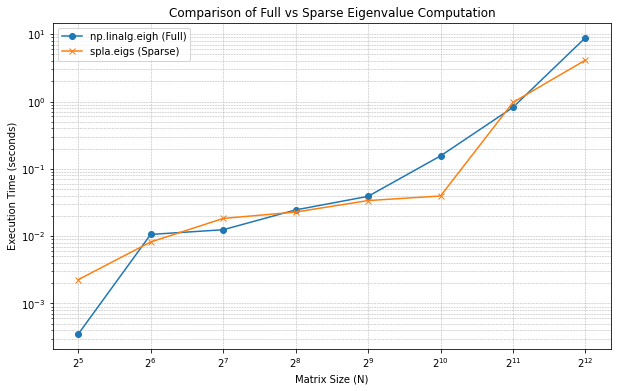

In [15]:
import numpy as np
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import time

sizes = [2**n for n in range(5, 13)]
k = 4  # Number of eigenvectors for sparse solver

eigh_times = []
eigs_times = []

for N in sizes:
    # Generate random Hermitian matrix
    M = np.random.rand(N, N)
    M = 0.5 * (M + M.T)

    # Timing np.linalg.eigh (full diagonalization)
    start = time.time()
    np.linalg.eigh(M)
    end = time.time()
    eigh_times.append(end - start)

    # Timing sparse diagonalization with scipy.sparse.linalg.eigs
    start = time.time()
    spla.eigs(M, k=min(k, N-1), which='LM')  # Ensure k < N for eigs
    end = time.time()
    eigs_times.append(end - start)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sizes, eigh_times, label='np.linalg.eigh (Full)', marker='o')
plt.plot(sizes, eigs_times, label='spla.eigs (Sparse)', marker='x')
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('Matrix Size (N)')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Full vs Sparse Eigenvalue Computation')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)